In [104]:
from tqdm import trange

import numpy as np

import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Module

from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

from sklearn import decomposition
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import normalize 
import copy
from mpl_toolkits import mplot3d

from sklearn.svm import SVC
from sklearn import svm
#%matplotlib inline 
#%matplotlib widget

## Datset

In [88]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()

)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

In [89]:
SIZE = 20000
idx = np.random.choice(60000, SIZE, replace=False)
training_data.data = training_data.data[idx]
training_data.targets = training_data.targets[idx]


In [108]:
X_train_np = np.array([data[0].numpy() for data in training_data])
y_train_np = np.array([data[1] for data in training_data])

In [109]:
#Reshape the training stess (60000, 28,28)->(60000, 28*28)
X_train_np = X_train_np.reshape(X_train_np.shape[0], -1)

In [110]:
#normalize input
X_train_np =  normalize(X_train_np)

In [111]:
X_test_np = np.array([data[0].numpy() for data in test_data])
y_test_np = np.array([data[1] for data in test_data])

In [112]:
X_test_np = X_test_np.reshape(X_test_np.shape[0], -1)

In [113]:
X_test_np =  normalize(X_test_np)

In [ ]:
tmp = "0 T-shirt/top,1 Trouser,2 Pullover,3 Dress,4 Coat,5 Sandal,6 Shirt,7 Sneaker,8 Bag,9 Ankle boot"
nto_labl = {i.split(' ')[0]: i.split(' ')[1] for i in tmp.split(',')}


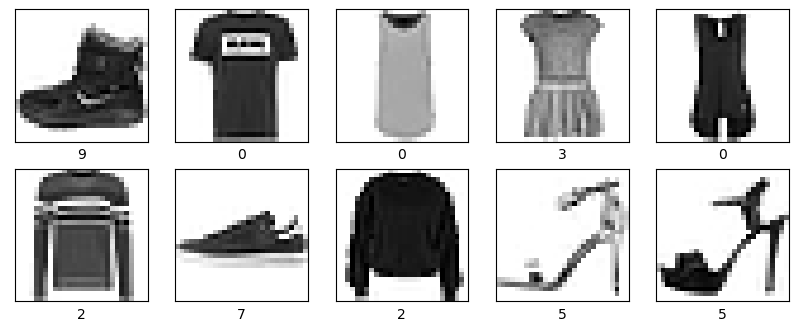

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(10):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i], cmap=plt.cm.binary)
    plt.xlabel(y_train[i])



## Understanding Data Geometry

### Linear

In [ ]:
lin_pca = decomposition.PCA(n_components=10)
X_train_pca = lin_pca.fit_transform(X)
X_train_pca.shape


(20000, 10)

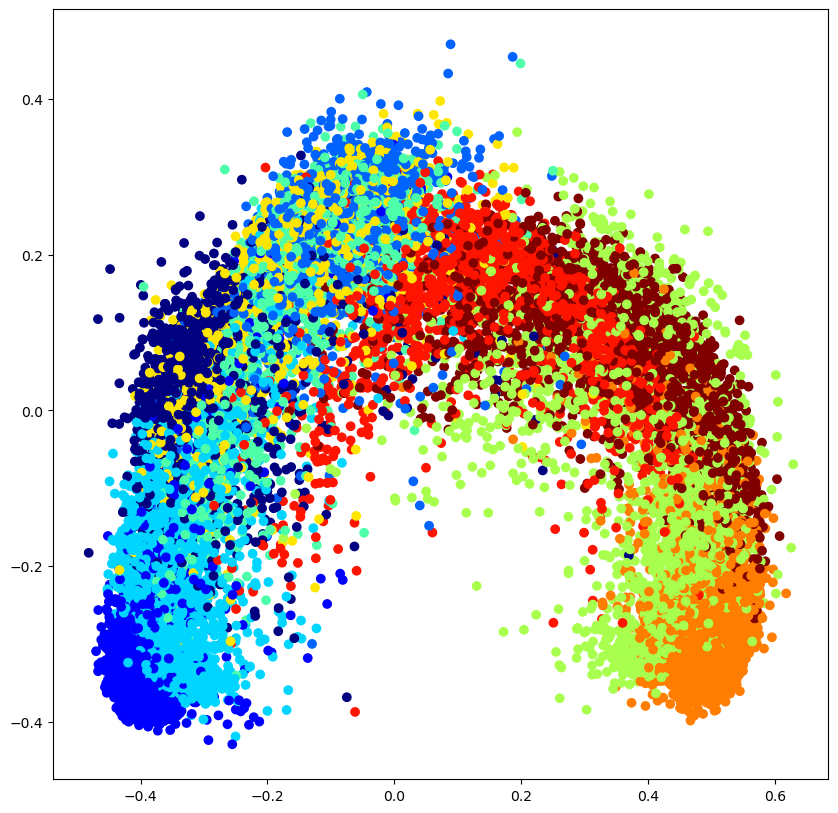

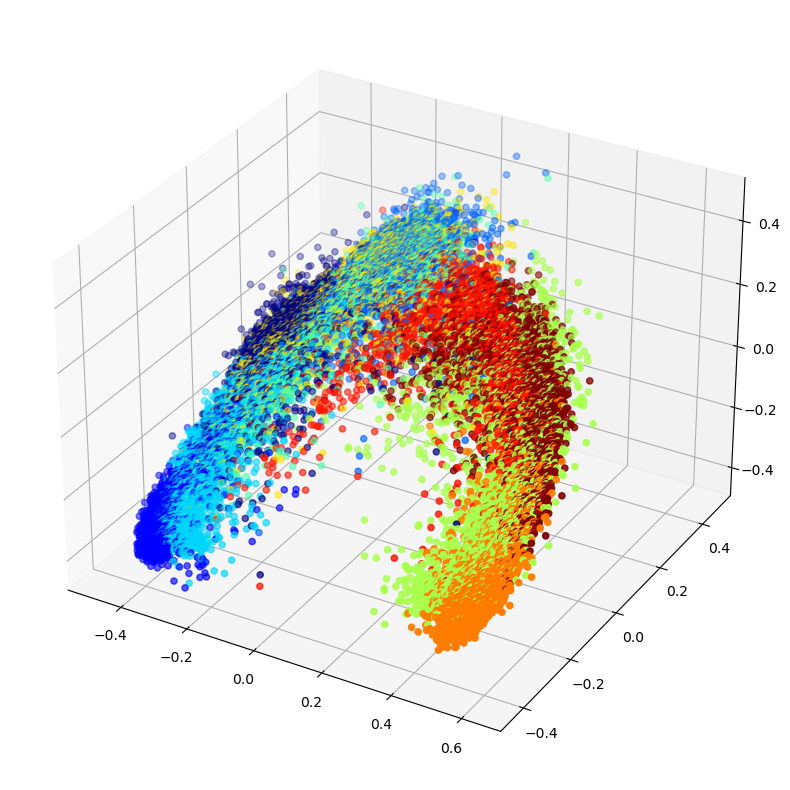

In [ ]:
#2d Plot
plt.figure(figsize=(10, 10))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y[:20000], cmap=plt.cm.get_cmap('jet', 10))
plt.show()
#3d Plot
plt.figure(figsize=(10, 10))
ax = plt.axes(projection ="3d")
ax.scatter3D(X_train_pca[:, 0], X_train_pca[:, 1],X_train_pca[:, 1],c=y[:20000], cmap=plt.cm.get_cmap('jet', 10) )



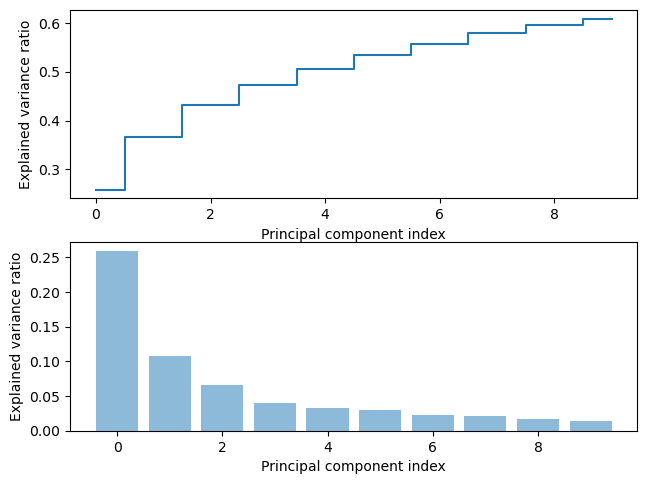

In [ ]:
cum_sum_eigenvalues = np.cumsum(lin_pca.explained_variance_ratio_)
fig, axs = plt.subplots(2,1)
fig.tight_layout()
axs[0].step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
axs[1].bar(range(0,len(lin_pca.explained_variance_ratio_)), lin_pca.explained_variance_ratio_, alpha=0.5, align='center', label='Individual explained variance')

for ax in axs.flat:
    ax.set(xlabel='Principal component index', ylabel='Explained variance ratio')
    


### Kernel PCA

#### RBF PCA

I first try with the default value for gamma which is
$\frac{1}{\mbox{number of classes}}$

In [ ]:
rbf_pca = decomposition.KernelPCA(n_components=3, kernel='rbf')
X_train_rbf_pca = rbf_pca.fit_transform(X)
X_train_rbf_pca.shape

(20000, 3)

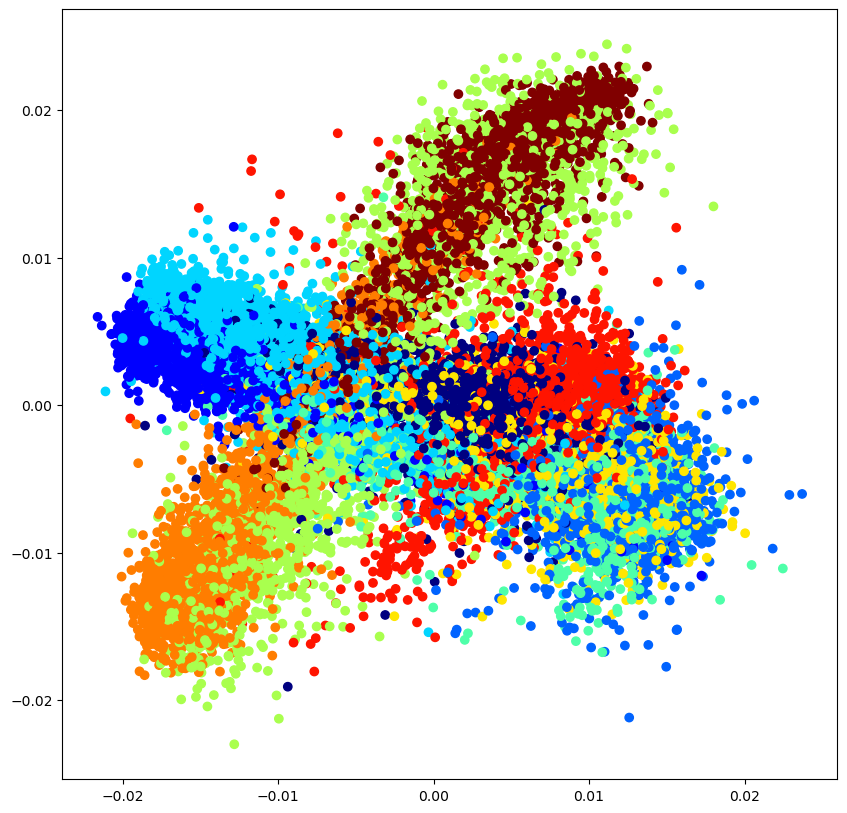

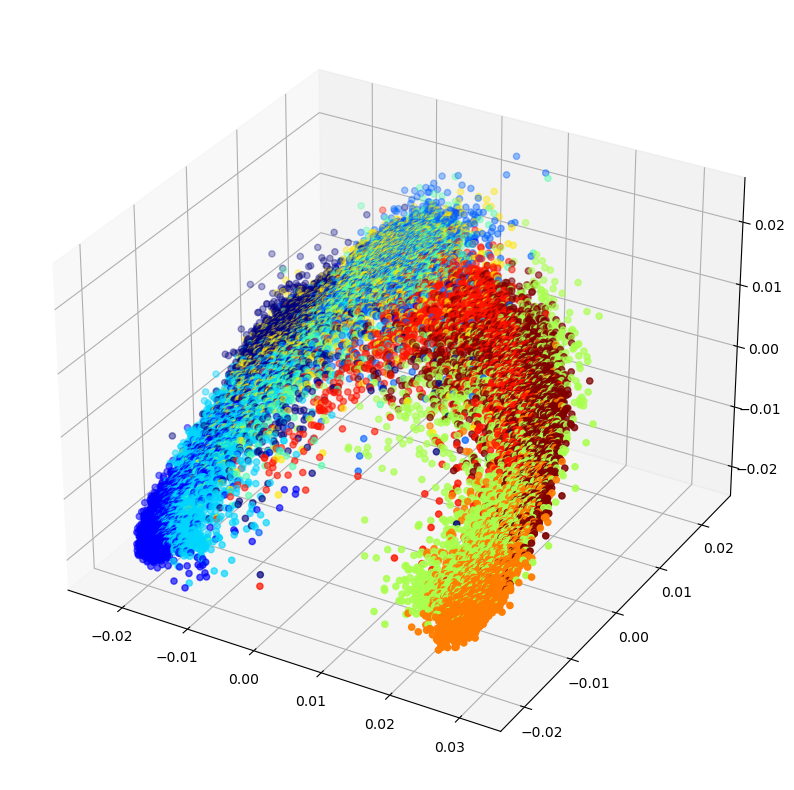

In [ ]:
#2d Plot
plt.figure(figsize=(10, 10))
plt.scatter(X_train_rbf_pca[:, 1], X_train_rbf_pca[:, 2], c=y[:20000], cmap=plt.cm.get_cmap('jet', 10))
plt.show()
#3d Plot
plt.figure(figsize=(10, 10))
ax = plt.axes(projection ="3d")
ax.scatter3D(X_train_rbf_pca[:, 0], X_train_rbf_pca[:, 1],X_train_rbf_pca[:, 1],c=y[:20000], cmap=plt.cm.get_cmap('jet', 10) )


In [ ]:
rbf_pca = decomposition.KernelPCA(n_components=3, kernel='rbf', gamma=3)
X_train_rbf_pca = rbf_pca.fit_transform(X)

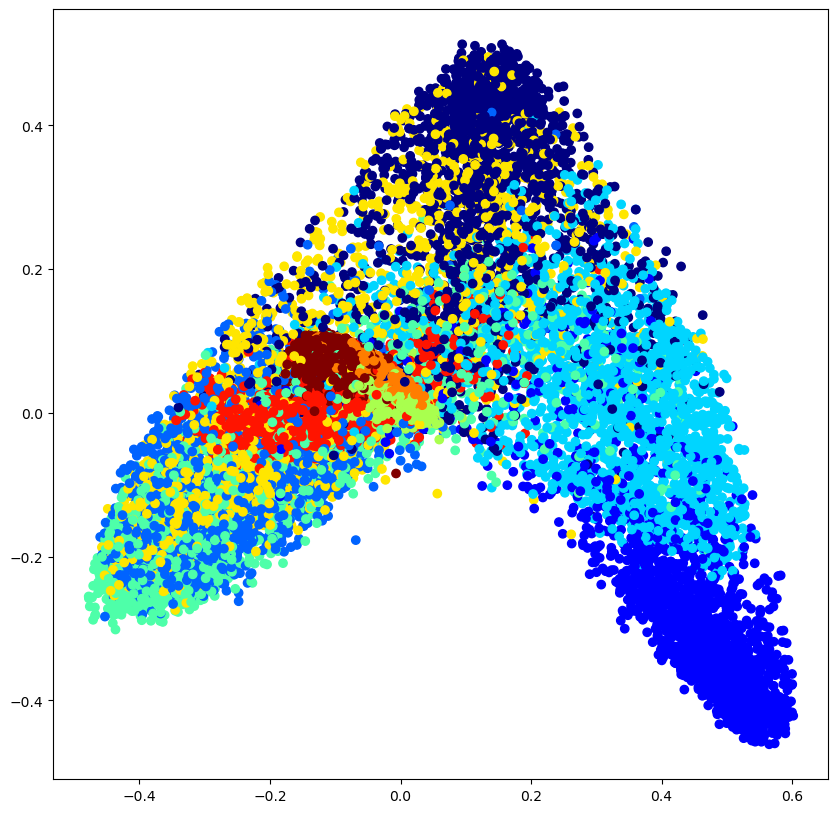

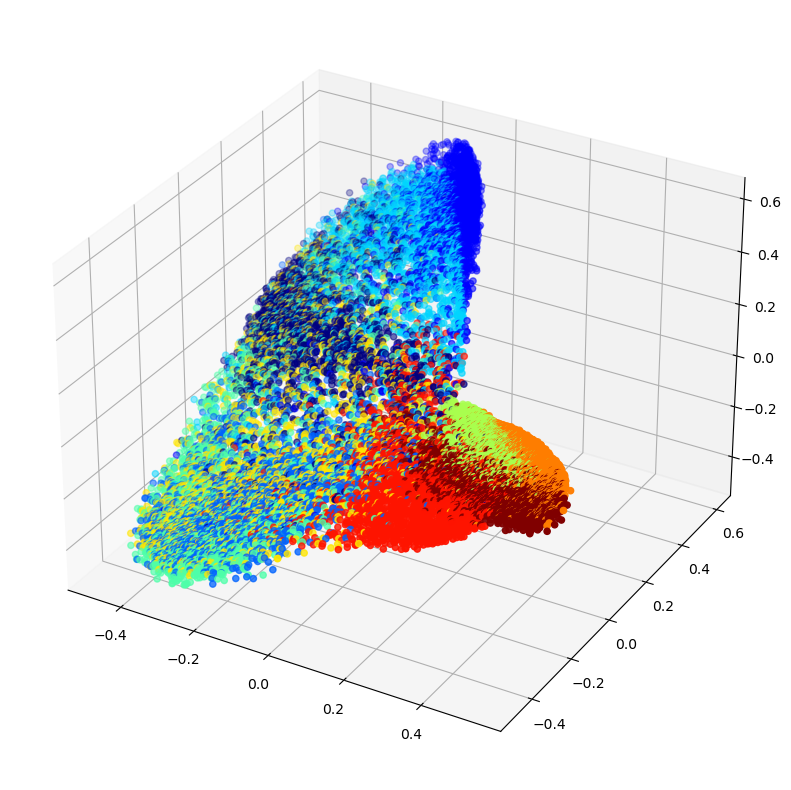

In [ ]:
#2d Plot
plt.figure(figsize=(10, 10))
plt.scatter(X_train_rbf_pca[:, 1], X_train_rbf_pca[:, 2], c=y[:20000], cmap=plt.cm.get_cmap('jet', 10))
plt.show()
#3d Plot
plt.figure(figsize=(10, 10))
ax = plt.axes(projection ="3d")
ax.scatter3D(X_train_rbf_pca[:, 0], X_train_rbf_pca[:, 1],X_train_rbf_pca[:, 1],c=y[:20000], cmap=plt.cm.get_cmap('jet', 10) )


### Polynomial Kernel

In [ ]:
poly_pca = decomposition.KernelPCA(n_components=3, kernel='poly', degree=15, gamma=0.1)
X_train_poly_pca = poly_pca.fit_transform(X)
X_train_poly_pca.shape

(20000, 3)

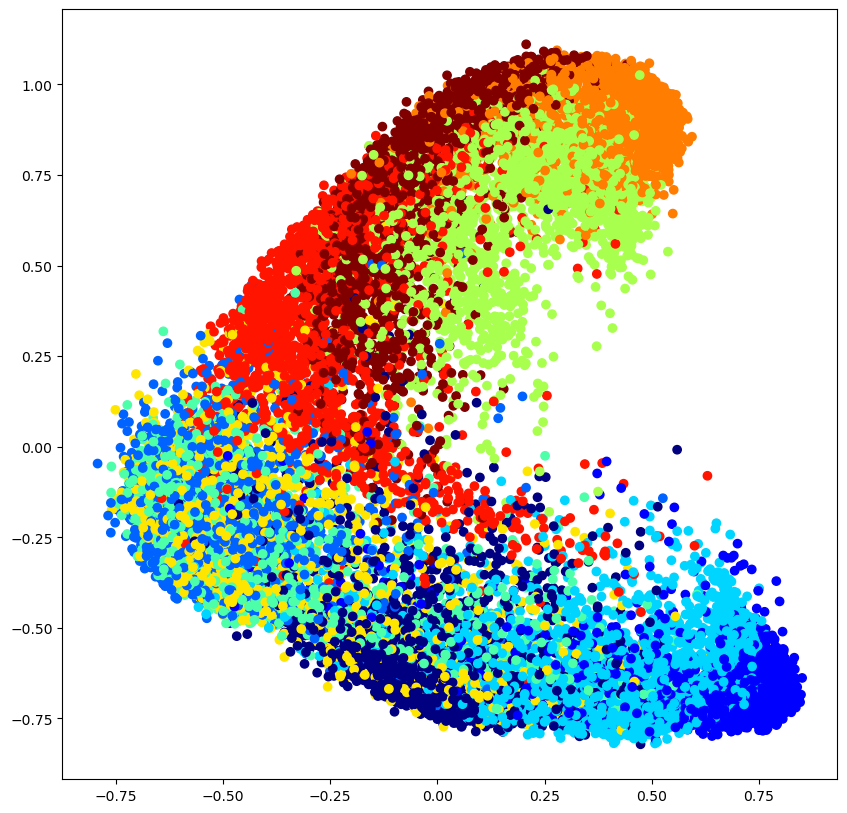

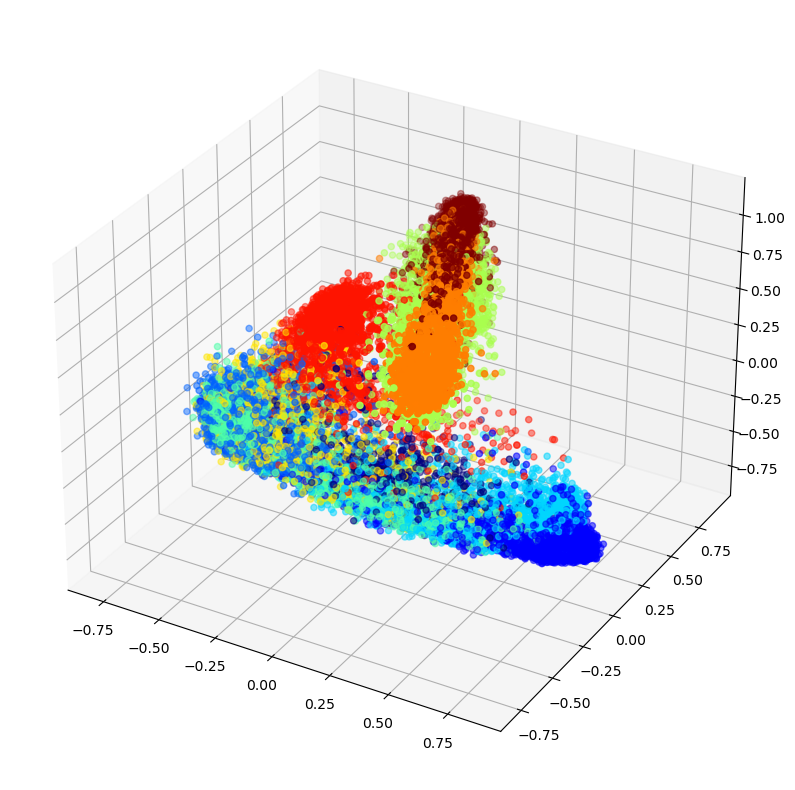

In [ ]:
#Plot 2D
plt.figure(figsize=(10, 10))
plt.scatter(X_train_poly_pca[:, 1], X_train_poly_pca[:, 0], c=y[:20000], cmap=plt.cm.get_cmap('jet', 10))
plt.show()
#Plot 3D
plt.figure(figsize=(10, 10))
ax = plt.axes(projection ="3d")
ax.scatter3D(X_train_poly_pca[:, 1], X_train_poly_pca[:, 2],X_train_poly_pca[:, 0],c=y[:20000], cmap=plt.cm.get_cmap('jet', 10) )

### Sigmoid

In [ ]:
poly_sig = decomposition.KernelPCA(n_components=3, kernel='sigmoid', degree=15, gamma=2.5)
X_train_poly_sig = poly_sig.fit_transform(X)
X_train_poly_sig.shape

(20000, 3)

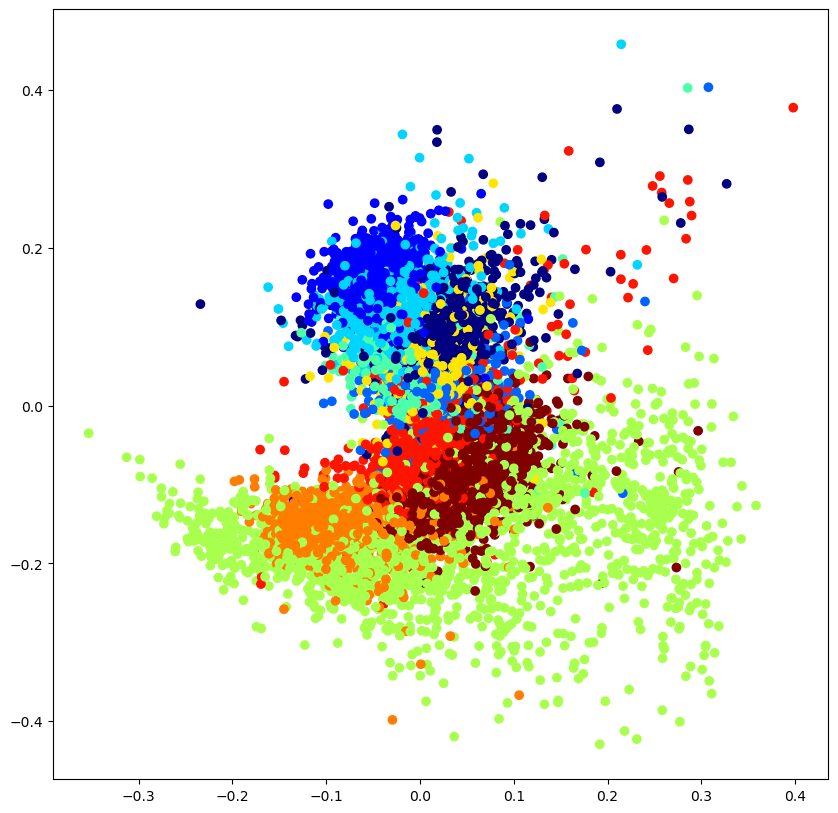

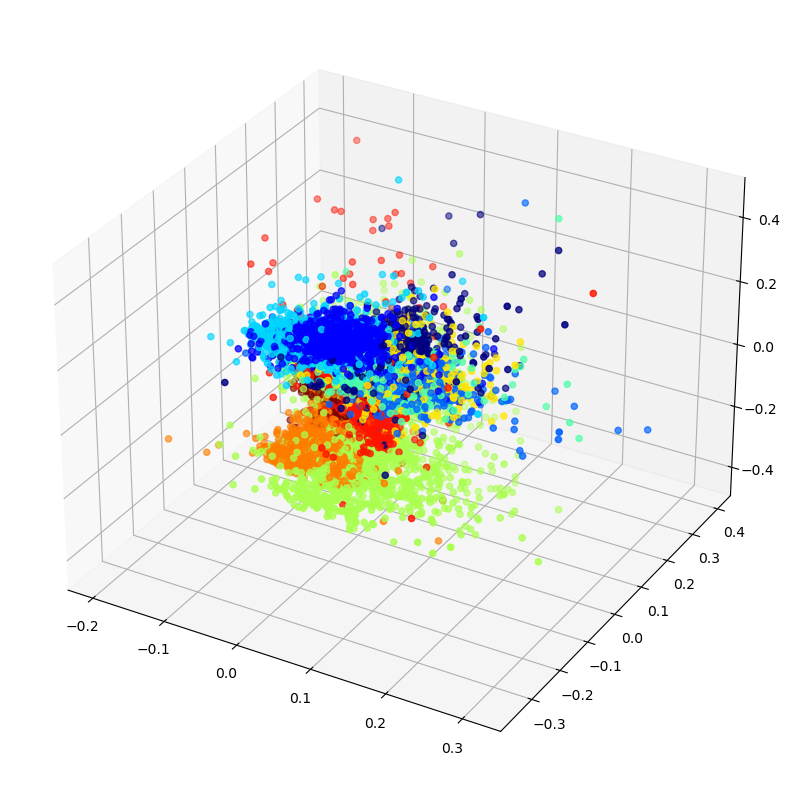

In [ ]:
#Plot 2D
plt.figure(figsize=(10, 10))
plt.scatter(X_train_poly_sig[:, 1], X_train_poly_sig[:, 0], c=y[:20000], cmap=plt.cm.get_cmap('jet', 10))
plt.show()
#Plot 3D
plt.figure(figsize=(10, 10))
ax = plt.axes(projection ="3d")
ax.scatter3D(X_train_poly_sig[:, 2], X_train_poly_sig[:, 1],X_train_poly_sig[:, 0],c=y[:20000], cmap=plt.cm.get_cmap('jet', 10) )


### Custom kernel

In [116]:
from sklearn.metrics.pairwise import rbf_kernel 
from sklearn.metrics.pairwise import polynomial_kernel
from sklearn.metrics.pairwise import chi2_kernel
from sklearn.metrics.pairwise import sigmoid_kernel
from sklearn.metrics.pairwise import linear_kernel
from scipy.linalg import eigh

In [118]:
rbfkernel = rbf_kernel(X_train_np[:5000],X_train_np[:5000], gamma=3)

In [120]:
rbfkernel1 = rbf_kernel(X_train_np[:5000], X_train_np[:5000], gamma=1.5)

In [121]:
sigkernel = sigmoid_kernel(X_train_np[:5000],X_train_np[:5000],gamma=2.5)

In [122]:
polykernel = polynomial_kernel(X_train_np[:5000],X_train_np[:5000], degree=2)

In [123]:
linkernel = linear_kernel(X_train_np[:5000],X_train_np[:5000])

In [124]:
gram = rbfkernel+2.5*sigkernel+sigkernel*rbfkernel1*polykernel+linkernel

In [131]:
kpca = decomposition.KernelPCA(n_components=10, kernel='precomputed')
X_train_custom = kpca.fit_transform(gram)

<ipython-input-129-f6c9dacc14e8>:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.scatter(X_train_custom[:, 1], X_train_custom[:, 0], c=y_train_np[:5000], cmap=plt.cm.get_cmap('jet', 10))


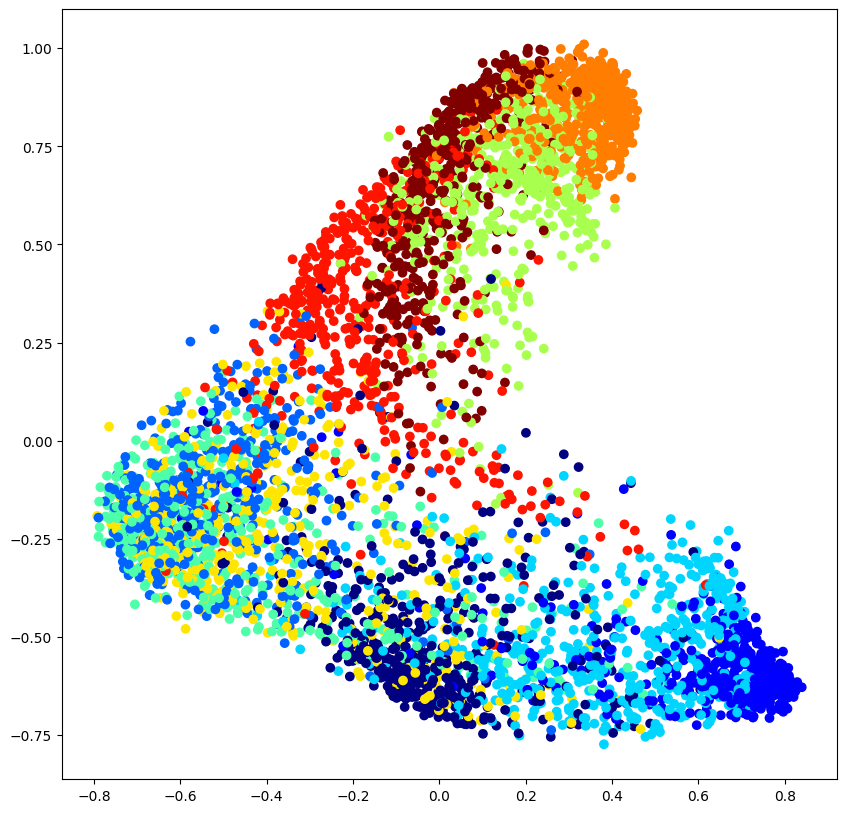

<ipython-input-129-f6c9dacc14e8>:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  ax.scatter3D(X_train_custom[:, 2], X_train_custom[:, 1],X_train_custom[:, 0],c=y_train_np[:5000], cmap=plt.cm.get_cmap('jet', 10) )


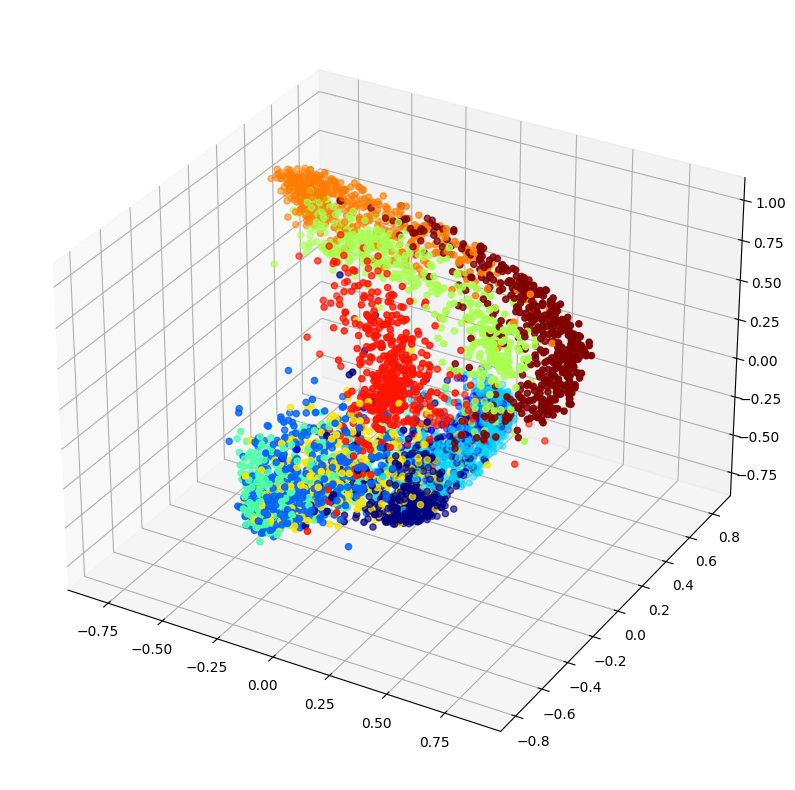

In [129]:
#Plot 2D
plt.figure(figsize=(10, 10))
plt.scatter(X_train_custom[:, 1], X_train_custom[:, 0], c=y_train_np[:5000], cmap=plt.cm.get_cmap('jet', 10))
plt.show()
#Plot 3D
plt.figure(figsize=(10, 10))
ax = plt.axes(projection ="3d")
ax.scatter3D(X_train_custom[:, 2], X_train_custom[:, 1],X_train_custom[:, 0],c=y_train_np[:5000], cmap=plt.cm.get_cmap('jet', 10) )


## Bridging *unsupervised* and *supervised*

#### Kernel


In [132]:
kpca = decomposition.PCA(n_components=10)
x_kpca = kpca.fit_transform(gram)


#### Kmeans

In [133]:
from sklearn.cluster import KMeans

km = KMeans(
    n_clusters=10, init='k-means++',
    n_init=10, max_iter=10000, 
    tol=1e-04, random_state=0
)
y_km = km.fit_predict(x_kpca)


In [ ]:
# import library
from sklearn.cluster import SpectralClustering

# create instance of model and fit to data
model = SpectralClustering(n_clusters=10)
y_km_spectral = model.fit_predict(x_kpca)

# access model labels
clusters = model.labels_

In [134]:
from sklearn.metrics.cluster import homogeneity_score
print({homogeneity_score(y_train_np[:20000],y_km)})
#print({homogeneity_score(y[:20000],y_km)})ù



{0.5850601685192403}


## (Supervised) classification

In [251]:
mask = y_train_np[y_km==9]
occ_count = np.bincount(mask)
argmax = np.argmax(occ_count)

In [255]:
np.unique(mask)

array([2, 5, 7, 8, 9])

In [257]:
occ_count

array([  0,   0,   1,   0,   0, 778,   0, 637,  27, 112])

In [303]:
map_index = {}
for j in range(10):
  mask = y_km[y_train_np==j]
  occ_count = np.bincount(mask)
  #occ_count = occ_count[occ_count!=0]
  argmax = np.argmax(occ_count)
  cond = True
  while cond:
    mapped_index = argmax
    if mapped_index in map_index.values():
      occ_count[argmax]=0
      prev_argmax = argmax
      argmax = np.argmax(occ_count)
      if argmax==0:
        map_index[j]=prev_argmax
        break
    else:
      map_index[j] = mapped_index
      cond = False

In [304]:
map_index

{0: 8, 1: 7, 2: 0, 3: 2, 4: 5, 5: 9, 6: 6, 7: 3, 8: 6, 9: 1}

In [315]:
from torch.utils.data import TensorDataset
data_train = X_train_np[:int(X_train_np.shape[0]*0.8)]
label_train = y_km[:int(y_km.shape[0]*0.8)]
data_val = X_train_np[int(X_train_np.shape[0]*0.8):]
label_val =y_km[int(y_km.shape[0]*0.8):]

training_data_km = torch.from_numpy(data_train).float()
val_data_km = torch.from_numpy(data_val).float()
train_label_km = torch.from_numpy(label_train).long()
val_label_km = torch.from_numpy(label_val).long()
training_data_km = TensorDataset(training_data_km, train_label_km)
val_data_km = TensorDataset(val_data_km, val_label_km)

In [262]:
# Loading the datasets
BATCH_SIZE = 64
train_loader_km = DataLoader(dataset=training_data_km, batch_size=BATCH_SIZE, shuffle=True)
val_loader_km = DataLoader(dataset=val_data_km, batch_size=BATCH_SIZE, shuffle=False)

### SVM

In [327]:
from sklearn.svm import SVC
from sklearn import svm
svm_models = []
for i in ['linear', 'rbf', 'poly', 'sigmoid']:
  svm_models.append(svm.SVC(kernel=i, C=1, decision_function_shape='ovo').fit(data_train,label_train))


In [328]:
svm_pred = []
for i in svm_models:
  svm_pred.append(i.predict(data_val))
  print(f'Accuracy  Kernel {i.kernel}: {i.score(data_val,label_val)}')


Accuracy  Kernel linear: 0.976
Accuracy  Kernel rbf: 0.97675
Accuracy  Kernel poly: 0.981
Accuracy  Kernel sigmoid: 0.93225


### MLP

In [14]:
# Hyperparameters
EPOCHS = 20
LEARNING_RATE = 0.01
MOMENTUM = 0.0
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [15]:
def get_batch_accuracy(logit, target, map_index=None):
    """Obtain accuracy for one batch of data"""
    if map_index is not None:
        logit = logit[:,list(map_index.values())]
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = (corrects / target.size(0))*100
    return accuracy.item()

In [16]:
@torch.no_grad()
def estimate_accuracy(model,val_loader):
    model.eval()
    val_acc = 0
    for i, (images, labels) in enumerate(val_loader):
        images = images.to(device)
        labels = labels.to(device)
        logits = model_f(images)
        loss = criterion(logits, labels)
        val_acc += get_batch_accuracy(logits, labels)
    model.train()
    return val_acc/i
    


In [62]:
class FNet(nn.Module):
        def __init__(self):
                super(FNet,self).__init__()
                self.fc1 = nn.Linear(28*28, 512)
                self.fc2 = nn.Linear(512,256)
                self.fc3 = nn.Linear(256,10)
                self.droput = nn.Dropout(0.1)

        def forward(self,x):
                x = x.view(-1,28*28)
                x = F.relu(self.fc1(x))
                x = self.droput(x)
                x = F.relu(self.fc2(x))
                x = self.droput(x)
                x = self.fc3(x)
               
                return x


In [22]:
model_f = FNet()
model_f = model_f.to(device) 

In [23]:
criterion = nn.CrossEntropyLoss()  # Loss function
optimizer = torch.optim.Adam(model_f.parameters(), lr=LEARNING_RATE)

In [273]:
train_loss = []
for epoch in trange(EPOCHS):
    train_running_loss = 0.0
    train_acc = 0.0

    model_f.train()  # Set the model to training mode: relevant for dropout, batchnorm, etc.

    # Actual (batch-wise) training step
    for i, (images, labels) in enumerate(train_loader_km):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass + (automated) BackProp + Loss computation
        logits = model_f(images)
        loss = criterion(logits, labels)

        optimizer.zero_grad()  # Reset the gradients to zero: otherwise they accumulate!
        loss.backward()  # Backpropagation

        # Update model params
        optimizer.step()

        train_running_loss += loss.detach().item()
        train_acc += get_batch_accuracy(logits, labels)

    model_f.eval()
    print(f"Epoch: {epoch+1} | Loss: {train_running_loss / i} | Train Accuracy: {train_acc/i} | Validation loss:{estimate_accuracy(model_f,val_loader_km)} ")
    train_loss.append(train_running_loss)

  1%|▏         | 1/80 [00:00<00:53,  1.47it/s]

Epoch: 1 | Loss: 0.26433570947064217 | Train Accuracy: 91.22740963855422 | Validation loss:96.32056451612904 


  2%|▎         | 2/80 [00:01<00:52,  1.50it/s]

Epoch: 2 | Loss: 0.12315234534786527 | Train Accuracy: 95.76430722891567 | Validation loss:95.96774193548387 


  4%|▍         | 3/80 [00:02<00:51,  1.49it/s]

Epoch: 3 | Loss: 0.0977958982406431 | Train Accuracy: 96.83107429718875 | Validation loss:97.65625 


  5%|▌         | 4/80 [00:02<00:51,  1.49it/s]

Epoch: 4 | Loss: 0.08594695508412747 | Train Accuracy: 97.23268072289157 | Validation loss:97.32862903225806 


  6%|▋         | 5/80 [00:03<00:50,  1.48it/s]

Epoch: 5 | Loss: 0.08374009515349586 | Train Accuracy: 97.53388554216868 | Validation loss:96.92540322580645 


  8%|▊         | 6/80 [00:04<00:50,  1.47it/s]

Epoch: 6 | Loss: 0.074464475363867 | Train Accuracy: 97.71586345381526 | Validation loss:98.56350806451613 


  9%|▉         | 7/80 [00:04<00:49,  1.47it/s]

Epoch: 7 | Loss: 0.06996585360875944 | Train Accuracy: 97.9543172690763 | Validation loss:98.26108870967742 


 10%|█         | 8/80 [00:05<00:48,  1.47it/s]

Epoch: 8 | Loss: 0.07497077968170732 | Train Accuracy: 97.67821285140562 | Validation loss:97.22782258064517 


 11%|█▏        | 9/80 [00:06<00:48,  1.46it/s]

Epoch: 9 | Loss: 0.07439804982476265 | Train Accuracy: 97.66566265060241 | Validation loss:98.76512096774194 


 12%|█▎        | 10/80 [00:06<00:48,  1.44it/s]

Epoch: 10 | Loss: 0.06903179820597052 | Train Accuracy: 97.98569277108433 | Validation loss:98.7399193548387 


 14%|█▍        | 11/80 [00:07<00:47,  1.45it/s]

Epoch: 11 | Loss: 0.06644824158071155 | Train Accuracy: 98.13002008032129 | Validation loss:98.10987903225806 


 15%|█▌        | 12/80 [00:08<00:48,  1.39it/s]

Epoch: 12 | Loss: 0.05827769211467251 | Train Accuracy: 98.41239959839358 | Validation loss:98.05947580645162 


 16%|█▋        | 13/80 [00:09<00:59,  1.12it/s]

Epoch: 13 | Loss: 0.06722935430455886 | Train Accuracy: 98.31827309236948 | Validation loss:98.3366935483871 


 18%|█▊        | 14/80 [00:10<00:58,  1.12it/s]

Epoch: 14 | Loss: 0.0556671884500919 | Train Accuracy: 98.52535140562249 | Validation loss:97.98387096774194 


 19%|█▉        | 15/80 [00:11<00:55,  1.17it/s]

Epoch: 15 | Loss: 0.058010237438727665 | Train Accuracy: 98.3433734939759 | Validation loss:98.41229838709677 


 20%|██        | 16/80 [00:11<00:51,  1.25it/s]

Epoch: 16 | Loss: 0.052971482492916014 | Train Accuracy: 98.58182730923694 | Validation loss:97.65625 


 21%|██▏       | 17/80 [00:12<00:48,  1.30it/s]

Epoch: 17 | Loss: 0.05171930296444727 | Train Accuracy: 98.60692771084338 | Validation loss:98.1350806451613 


 22%|██▎       | 18/80 [00:13<00:45,  1.35it/s]

Epoch: 18 | Loss: 0.05020235487176704 | Train Accuracy: 98.644578313253 | Validation loss:98.05947580645162 


 24%|██▍       | 19/80 [00:13<00:44,  1.38it/s]

Epoch: 19 | Loss: 0.04650137728093244 | Train Accuracy: 98.86420682730923 | Validation loss:98.36189516129032 


 25%|██▌       | 20/80 [00:14<00:42,  1.42it/s]

Epoch: 20 | Loss: 0.05529852445007313 | Train Accuracy: 98.55672690763052 | Validation loss:98.51310483870968 


 26%|██▋       | 21/80 [00:15<00:45,  1.29it/s]

Epoch: 21 | Loss: 0.04316877459943104 | Train Accuracy: 99.07128514056225 | Validation loss:98.00907258064517 


 28%|██▊       | 22/80 [00:16<00:45,  1.28it/s]

Epoch: 22 | Loss: 0.03922076192887848 | Train Accuracy: 99.15913654618474 | Validation loss:98.96673387096774 


 29%|██▉       | 23/80 [00:17<00:43,  1.33it/s]

Epoch: 23 | Loss: 0.04976585372574356 | Train Accuracy: 98.78263052208835 | Validation loss:98.5383064516129 


 30%|███       | 24/80 [00:17<00:41,  1.36it/s]

Epoch: 24 | Loss: 0.04243748031160841 | Train Accuracy: 99.15913654618474 | Validation loss:98.00907258064517 


 31%|███▏      | 25/80 [00:18<00:39,  1.39it/s]

Epoch: 25 | Loss: 0.04273980097301925 | Train Accuracy: 98.9206827309237 | Validation loss:98.00907258064517 


 32%|███▎      | 26/80 [00:19<00:38,  1.41it/s]

Epoch: 26 | Loss: 0.05187771830715503 | Train Accuracy: 98.78890562248996 | Validation loss:98.23588709677419 


 34%|███▍      | 27/80 [00:19<00:37,  1.43it/s]

Epoch: 27 | Loss: 0.0552706661732095 | Train Accuracy: 98.80145582329317 | Validation loss:98.71471774193549 


 35%|███▌      | 28/80 [00:20<00:36,  1.44it/s]

Epoch: 28 | Loss: 0.04734179813084735 | Train Accuracy: 98.87675702811245 | Validation loss:98.03427419354838 


 36%|███▋      | 29/80 [00:21<00:36,  1.38it/s]

Epoch: 29 | Loss: 0.039622900814559485 | Train Accuracy: 99.15286144578313 | Validation loss:97.98387096774194 


 38%|███▊      | 30/80 [00:22<00:38,  1.29it/s]

Epoch: 30 | Loss: 0.04017762342336353 | Train Accuracy: 99.13403614457832 | Validation loss:98.89112903225806 


 39%|███▉      | 31/80 [00:23<00:39,  1.24it/s]

Epoch: 31 | Loss: 0.04455518794370381 | Train Accuracy: 99.09011044176707 | Validation loss:98.7399193548387 


 40%|████      | 32/80 [00:23<00:37,  1.29it/s]

Epoch: 32 | Loss: 0.04434828149261379 | Train Accuracy: 98.9269578313253 | Validation loss:98.66431451612904 


 41%|████▏     | 33/80 [00:24<00:34,  1.35it/s]

Epoch: 33 | Loss: 0.040335526425673354 | Train Accuracy: 99.18423694779116 | Validation loss:98.76512096774194 


 42%|████▎     | 34/80 [00:25<00:33,  1.38it/s]

Epoch: 34 | Loss: 0.037701908832235474 | Train Accuracy: 99.17168674698796 | Validation loss:99.09274193548387 


 44%|████▍     | 35/80 [00:25<00:34,  1.31it/s]

Epoch: 35 | Loss: 0.041387207543883704 | Train Accuracy: 99.24698795180723 | Validation loss:98.26108870967742 


 45%|████▌     | 36/80 [00:26<00:32,  1.33it/s]

Epoch: 36 | Loss: 0.04742171327827426 | Train Accuracy: 98.98343373493977 | Validation loss:98.63911290322581 


 46%|████▋     | 37/80 [00:27<00:31,  1.37it/s]

Epoch: 37 | Loss: 0.04065670483335025 | Train Accuracy: 99.20933734939759 | Validation loss:98.9163306451613 


 48%|████▊     | 38/80 [00:28<00:30,  1.39it/s]

Epoch: 38 | Loss: 0.03396819510042946 | Train Accuracy: 99.34738955823293 | Validation loss:97.50504032258064 


 49%|████▉     | 39/80 [00:28<00:29,  1.41it/s]

Epoch: 39 | Loss: 0.061226639296320905 | Train Accuracy: 98.77008032128514 | Validation loss:98.08467741935483 


 50%|█████     | 40/80 [00:29<00:27,  1.43it/s]

Epoch: 40 | Loss: 0.03877850090764579 | Train Accuracy: 99.29091365461848 | Validation loss:99.21875 


 51%|█████▏    | 41/80 [00:30<00:27,  1.44it/s]

Epoch: 41 | Loss: 0.02653719086144947 | Train Accuracy: 99.54819277108433 | Validation loss:98.51310483870968 


 52%|█████▎    | 42/80 [00:30<00:26,  1.46it/s]

Epoch: 42 | Loss: 0.041922654134786824 | Train Accuracy: 99.19051204819277 | Validation loss:98.51310483870968 


 54%|█████▍    | 43/80 [00:31<00:25,  1.47it/s]

Epoch: 43 | Loss: 0.02866457487504656 | Train Accuracy: 99.52309236947791 | Validation loss:99.09274193548387 


 55%|█████▌    | 44/80 [00:32<00:24,  1.47it/s]

Epoch: 44 | Loss: 0.04491477999086768 | Train Accuracy: 99.17796184738955 | Validation loss:98.26108870967742 


 56%|█████▋    | 45/80 [00:32<00:24,  1.45it/s]

Epoch: 45 | Loss: 0.04042234974750832 | Train Accuracy: 99.22816265060241 | Validation loss:98.96673387096774 


 57%|█████▊    | 46/80 [00:33<00:24,  1.38it/s]

Epoch: 46 | Loss: 0.036561417291990486 | Train Accuracy: 99.32228915662651 | Validation loss:99.26915322580645 


 59%|█████▉    | 47/80 [00:34<00:25,  1.30it/s]

Epoch: 47 | Loss: 0.03306749331728409 | Train Accuracy: 99.39131526104417 | Validation loss:98.7399193548387 


 60%|██████    | 48/80 [00:35<00:25,  1.25it/s]

Epoch: 48 | Loss: 0.039102240566096104 | Train Accuracy: 99.30973895582329 | Validation loss:98.68951612903226 


 61%|██████▏   | 49/80 [00:36<00:23,  1.31it/s]

Epoch: 49 | Loss: 0.027467762672076568 | Train Accuracy: 99.4226907630522 | Validation loss:98.86592741935483 


 62%|██████▎   | 50/80 [00:36<00:21,  1.36it/s]

Epoch: 50 | Loss: 0.032751745338316825 | Train Accuracy: 99.39131526104417 | Validation loss:99.19354838709677 


 64%|██████▍   | 51/80 [00:37<00:20,  1.40it/s]

Epoch: 51 | Loss: 0.030216089959139936 | Train Accuracy: 99.54819277108433 | Validation loss:98.76512096774194 


 65%|██████▌   | 52/80 [00:38<00:19,  1.42it/s]

Epoch: 52 | Loss: 0.029517782298500102 | Train Accuracy: 99.52309236947791 | Validation loss:98.31149193548387 


 66%|██████▋   | 53/80 [00:38<00:18,  1.44it/s]

Epoch: 53 | Loss: 0.03375516476726298 | Train Accuracy: 99.25953815261045 | Validation loss:98.61391129032258 


 68%|██████▊   | 54/80 [00:39<00:17,  1.45it/s]

Epoch: 54 | Loss: 0.03360593525988052 | Train Accuracy: 99.45406626506023 | Validation loss:98.86592741935483 


 69%|██████▉   | 55/80 [00:40<00:17,  1.47it/s]

Epoch: 55 | Loss: 0.02471708831852807 | Train Accuracy: 99.62976907630522 | Validation loss:98.9163306451613 


 70%|███████   | 56/80 [00:40<00:16,  1.47it/s]

Epoch: 56 | Loss: 0.03220949024638188 | Train Accuracy: 99.44151606425703 | Validation loss:98.23588709677419 


 71%|███████▏  | 57/80 [00:41<00:17,  1.34it/s]

Epoch: 57 | Loss: 0.04386552513910628 | Train Accuracy: 99.29718875502007 | Validation loss:98.38709677419355 


 72%|███████▎  | 58/80 [00:42<00:17,  1.22it/s]

Epoch: 58 | Loss: 0.032067371831131994 | Train Accuracy: 99.410140562249 | Validation loss:97.9586693548387 


 74%|███████▍  | 59/80 [00:44<00:20,  1.00it/s]

Epoch: 59 | Loss: 0.04057838418789818 | Train Accuracy: 99.34111445783132 | Validation loss:97.93346774193549 


 75%|███████▌  | 60/80 [00:44<00:19,  1.05it/s]

Epoch: 60 | Loss: 0.03671138645627234 | Train Accuracy: 99.44151606425703 | Validation loss:98.76512096774194 


 76%|███████▋  | 61/80 [00:45<00:17,  1.12it/s]

Epoch: 61 | Loss: 0.03951655012060363 | Train Accuracy: 99.65486947791165 | Validation loss:97.47983870967742 


 78%|███████▊  | 62/80 [00:46<00:15,  1.13it/s]

Epoch: 62 | Loss: 0.037752875611304665 | Train Accuracy: 99.32228915662651 | Validation loss:98.76512096774194 


 79%|███████▉  | 63/80 [00:47<00:14,  1.14it/s]

Epoch: 63 | Loss: 0.024432957813700792 | Train Accuracy: 99.7113453815261 | Validation loss:98.66431451612904 


 80%|████████  | 64/80 [00:48<00:13,  1.20it/s]

Epoch: 64 | Loss: 0.03225234918272142 | Train Accuracy: 99.47289156626506 | Validation loss:98.58870967741936 


 81%|████████▏ | 65/80 [00:48<00:11,  1.28it/s]

Epoch: 65 | Loss: 0.0265052048151733 | Train Accuracy: 99.63604417670683 | Validation loss:99.09274193548387 


 82%|████████▎ | 66/80 [00:49<00:10,  1.34it/s]

Epoch: 66 | Loss: 0.029744969948399057 | Train Accuracy: 99.6046686746988 | Validation loss:98.51310483870968 


 84%|████████▍ | 67/80 [00:50<00:09,  1.38it/s]

Epoch: 67 | Loss: 0.028106221323666313 | Train Accuracy: 99.57329317269077 | Validation loss:99.09274193548387 


 85%|████████▌ | 68/80 [00:50<00:08,  1.42it/s]

Epoch: 68 | Loss: 0.02622529096462098 | Train Accuracy: 99.66741967871486 | Validation loss:99.01713709677419 


 86%|████████▋ | 69/80 [00:51<00:07,  1.45it/s]

Epoch: 69 | Loss: 0.026634847875842877 | Train Accuracy: 99.58584337349397 | Validation loss:98.76512096774194 


 88%|████████▊ | 70/80 [00:52<00:06,  1.45it/s]

Epoch: 70 | Loss: 0.03389023971376227 | Train Accuracy: 99.62349397590361 | Validation loss:97.53024193548387 


 89%|████████▉ | 71/80 [00:52<00:06,  1.47it/s]

Epoch: 71 | Loss: 0.04390014194073174 | Train Accuracy: 99.34738955823293 | Validation loss:97.88306451612904 


 90%|█████████ | 72/80 [00:53<00:05,  1.48it/s]

Epoch: 72 | Loss: 0.024965458842487635 | Train Accuracy: 99.74899598393574 | Validation loss:98.84072580645162 


 91%|█████████▏| 73/80 [00:54<00:04,  1.48it/s]

Epoch: 73 | Loss: 0.03128699450364336 | Train Accuracy: 99.52309236947791 | Validation loss:99.16834677419355 


 92%|█████████▎| 74/80 [00:54<00:04,  1.49it/s]

Epoch: 74 | Loss: 0.02795671897503605 | Train Accuracy: 99.67996987951807 | Validation loss:98.56350806451613 


 94%|█████████▍| 75/80 [00:55<00:03,  1.50it/s]

Epoch: 75 | Loss: 0.030444776967756645 | Train Accuracy: 99.617218875502 | Validation loss:99.06754032258064 


 95%|█████████▌| 76/80 [00:56<00:02,  1.49it/s]

Epoch: 76 | Loss: 0.024672467242909994 | Train Accuracy: 99.71762048192771 | Validation loss:98.58870967741936 


 96%|█████████▋| 77/80 [00:56<00:02,  1.49it/s]

Epoch: 77 | Loss: 0.03401173765152898 | Train Accuracy: 99.5105421686747 | Validation loss:99.09274193548387 


 98%|█████████▊| 78/80 [00:57<00:01,  1.49it/s]

Epoch: 78 | Loss: 0.035606966988480676 | Train Accuracy: 99.44151606425703 | Validation loss:98.81552419354838 


 99%|█████████▉| 79/80 [00:58<00:00,  1.40it/s]

Epoch: 79 | Loss: 0.031349896056248015 | Train Accuracy: 99.6109437751004 | Validation loss:98.81552419354838 


100%|██████████| 80/80 [00:59<00:00,  1.35it/s]

Epoch: 80 | Loss: 0.018898088153705375 | Train Accuracy: 99.76154618473896 | Validation loss:98.9163306451613 


### LeNet

In [316]:
#reshape data (1,784) -> (1,28,28)
data_train_cnn = torch.from_numpy(data_train).float()
label_train_cnn = torch.from_numpy(label_train).long()
data_val_cnn = torch.from_numpy(data_val).float()
label_val_cnn = torch.from_numpy(label_val).long()
data_train_cnn = data_train_cnn.view(-1,1,28,28)
data_val_cnn =  data_val_cnn.view(-1,1,28,28)

In [317]:
training_data_cnn = TensorDataset(data_train_cnn, label_train_cnn)
val_data_cnn = TensorDataset(data_val_cnn, label_val_cnn)
training_loader_cnn = DataLoader(training_data_cnn, batch_size=128, shuffle=True)
validation_loader_cnn = DataLoader(val_data_cnn, batch_size=128, shuffle=True)

In [79]:
class LeNet(Module):
    def __init__(self, numChannels, classes):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=numChannels, out_channels=20,
            kernel_size=(5, 5))
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

        self.conv2 = nn.Conv2d(in_channels=20, out_channels=50,
            kernel_size=(5, 5))
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

        self.fc1 = nn.Linear(in_features=800, out_features=500)
        self.relu3 = nn.ReLU()

        self.fc2 = nn.Linear(in_features=500, out_features=classes)
        self.logSoftmax = nn.LogSoftmax(dim=1)
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)
        
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.relu3(x)
        output = self.fc2(x)
        #output = self.logSoftmax(x)
        return output

In [319]:
model_l = LeNet(1,10)
model_l = model_l.to(device) 

In [320]:
EPOCHS =  50 # Number of times the whole (training) dataset is used for training
LR =  0.001

criterion = nn.CrossEntropyLoss()  # Loss function
optimizer = torch.optim.Adam(model_l.parameters(), lr=LR)

In [321]:
train_loss = []
for epoch in trange(EPOCHS):
    train_running_loss = 0.0
    train_acc = 0.0

    model_l.train()  # Set the model to training mode: relevant for dropout, batchnorm, etc.

    # Actual (batch-wise) training step
    for i, (images, labels) in enumerate(training_loader_cnn):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass + (automated) BackProp + Loss computation
        logits = model_l(images)
        loss = criterion(logits, labels)

        optimizer.zero_grad()  # Reset the gradients to zero: otherwise they accumulate!
        loss.backward()  # Backpropagation

        # Update model params
        optimizer.step()

        train_running_loss += loss.detach().item()
        train_acc += get_batch_accuracy(logits, labels)

    model_l.eval()
    print(f"Epoch: {epoch+1} | Loss: {train_running_loss / i} | Train Accuracy: {train_acc/i} | Validation accuracy:{estimate_accuracy(model_f,validation_loader_cnn)}")
    train_loss.append(train_running_loss)

  2%|▏         | 1/50 [00:00<00:23,  2.07it/s]

Epoch: 1 | Loss: 1.2758930774946367 | Train Accuracy: 55.94128024193548 | Validation accuracy:100.55443548387096


  4%|▍         | 2/50 [00:00<00:22,  2.12it/s]

Epoch: 2 | Loss: 0.23259881817765773 | Train Accuracy: 92.0929939516129 | Validation accuracy:100.40322580645162


  6%|▌         | 3/50 [00:01<00:22,  2.12it/s]

Epoch: 3 | Loss: 0.16262982268967935 | Train Accuracy: 94.68876008064517 | Validation accuracy:100.55443548387096


  8%|▊         | 4/50 [00:01<00:23,  1.99it/s]

Epoch: 4 | Loss: 0.13129245045204316 | Train Accuracy: 95.57081653225806 | Validation accuracy:100.55443548387096


 10%|█         | 5/50 [00:02<00:24,  1.83it/s]

Epoch: 5 | Loss: 0.11855769055264612 | Train Accuracy: 96.2008568548387 | Validation accuracy:100.40322580645162


 12%|█▏        | 6/50 [00:03<00:25,  1.74it/s]

Epoch: 6 | Loss: 0.10247181905733962 | Train Accuracy: 96.63558467741936 | Validation accuracy:100.4788306451613


 14%|█▍        | 7/50 [00:03<00:25,  1.69it/s]

Epoch: 7 | Loss: 0.09102604105587929 | Train Accuracy: 97.08921370967742 | Validation accuracy:100.55443548387096


 16%|█▌        | 8/50 [00:04<00:23,  1.75it/s]

Epoch: 8 | Loss: 0.08792401707520889 | Train Accuracy: 97.20262096774194 | Validation accuracy:100.40322580645162


 18%|█▊        | 9/50 [00:04<00:22,  1.86it/s]

Epoch: 9 | Loss: 0.0836937554901646 | Train Accuracy: 97.33492943548387 | Validation accuracy:100.4788306451613


 20%|██        | 10/50 [00:05<00:20,  1.94it/s]

Epoch: 10 | Loss: 0.08071644855062327 | Train Accuracy: 97.41053427419355 | Validation accuracy:100.55443548387096


 22%|██▏       | 11/50 [00:05<00:19,  1.99it/s]

Epoch: 11 | Loss: 0.07527544118103481 | Train Accuracy: 97.86416330645162 | Validation accuracy:100.55443548387096


 24%|██▍       | 12/50 [00:06<00:18,  2.02it/s]

Epoch: 12 | Loss: 0.07068449258804321 | Train Accuracy: 97.88306451612904 | Validation accuracy:100.4788306451613


 26%|██▌       | 13/50 [00:06<00:18,  2.03it/s]

Epoch: 13 | Loss: 0.07077063797342201 | Train Accuracy: 97.80745967741936 | Validation accuracy:100.40322580645162


 28%|██▊       | 14/50 [00:07<00:17,  2.04it/s]

Epoch: 14 | Loss: 0.06354550393899122 | Train Accuracy: 98.29259072580645 | Validation accuracy:100.40322580645162


 30%|███       | 15/50 [00:07<00:17,  2.06it/s]

Epoch: 15 | Loss: 0.06430582998080119 | Train Accuracy: 98.17288306451613 | Validation accuracy:100.55443548387096


 32%|███▏      | 16/50 [00:08<00:16,  2.07it/s]

Epoch: 16 | Loss: 0.05821880204002223 | Train Accuracy: 98.45010080645162 | Validation accuracy:100.40322580645162


 34%|███▍      | 17/50 [00:08<00:15,  2.07it/s]

Epoch: 17 | Loss: 0.05490145000869468 | Train Accuracy: 98.49420362903226 | Validation accuracy:100.40322580645162


 36%|███▌      | 18/50 [00:09<00:15,  2.08it/s]

Epoch: 18 | Loss: 0.05777821686839865 | Train Accuracy: 98.46900201612904 | Validation accuracy:100.55443548387096


 38%|███▊      | 19/50 [00:09<00:14,  2.09it/s]

Epoch: 19 | Loss: 0.05803933567667921 | Train Accuracy: 98.22328629032258 | Validation accuracy:100.4788306451613


 40%|████      | 20/50 [00:10<00:14,  2.08it/s]

Epoch: 20 | Loss: 0.0552742697989508 | Train Accuracy: 98.60131048387096 | Validation accuracy:100.4788306451613


 42%|████▏     | 21/50 [00:10<00:14,  2.07it/s]

Epoch: 21 | Loss: 0.05912269768305123 | Train Accuracy: 98.3303931451613 | Validation accuracy:100.4788306451613


 44%|████▍     | 22/50 [00:11<00:13,  2.09it/s]

Epoch: 22 | Loss: 0.04921203396553474 | Train Accuracy: 98.77772177419355 | Validation accuracy:100.4788306451613


 46%|████▌     | 23/50 [00:11<00:12,  2.11it/s]

Epoch: 23 | Loss: 0.05106907213226922 | Train Accuracy: 98.74621975806451 | Validation accuracy:100.55443548387096


 48%|████▊     | 24/50 [00:11<00:12,  2.11it/s]

Epoch: 24 | Loss: 0.049567909287889636 | Train Accuracy: 98.75252016129032 | Validation accuracy:100.55443548387096


 50%|█████     | 25/50 [00:12<00:11,  2.11it/s]

Epoch: 25 | Loss: 0.04741592349995288 | Train Accuracy: 98.84072580645162 | Validation accuracy:100.55443548387096


 52%|█████▏    | 26/50 [00:12<00:11,  2.10it/s]

Epoch: 26 | Loss: 0.051836890115913366 | Train Accuracy: 98.84072580645162 | Validation accuracy:100.4788306451613


 54%|█████▍    | 27/50 [00:13<00:10,  2.10it/s]

Epoch: 27 | Loss: 0.041757994594292774 | Train Accuracy: 99.16834677419355 | Validation accuracy:100.40322580645162


 56%|█████▌    | 28/50 [00:13<00:10,  2.10it/s]

Epoch: 28 | Loss: 0.0415772296781201 | Train Accuracy: 99.04233870967742 | Validation accuracy:100.4788306451613


 58%|█████▊    | 29/50 [00:14<00:10,  1.95it/s]

Epoch: 29 | Loss: 0.04891951879366271 | Train Accuracy: 98.81552419354838 | Validation accuracy:100.55443548387096


 60%|██████    | 30/50 [00:15<00:10,  1.83it/s]

Epoch: 30 | Loss: 0.04122906317183327 | Train Accuracy: 99.18094758064517 | Validation accuracy:100.32762096774194


 62%|██████▏   | 31/50 [00:15<00:10,  1.76it/s]

Epoch: 31 | Loss: 0.036532711322163985 | Train Accuracy: 99.40776209677419 | Validation accuracy:100.4788306451613


 64%|██████▍   | 32/50 [00:16<00:10,  1.70it/s]

Epoch: 32 | Loss: 0.03565963912912975 | Train Accuracy: 99.48966733870968 | Validation accuracy:100.55443548387096


 66%|██████▌   | 33/50 [00:16<00:09,  1.81it/s]

Epoch: 33 | Loss: 0.037945973129206965 | Train Accuracy: 99.19984879032258 | Validation accuracy:100.4788306451613


 68%|██████▊   | 34/50 [00:17<00:08,  1.78it/s]

Epoch: 34 | Loss: 0.03391506776754414 | Train Accuracy: 99.42036290322581 | Validation accuracy:100.4788306451613


 70%|███████   | 35/50 [00:18<00:08,  1.75it/s]

Epoch: 35 | Loss: 0.03752834877494963 | Train Accuracy: 99.33215725806451 | Validation accuracy:100.32762096774194


 72%|███████▏  | 36/50 [00:18<00:07,  1.84it/s]

Epoch: 36 | Loss: 0.03509672740924983 | Train Accuracy: 99.47076612903226 | Validation accuracy:100.55443548387096


 74%|███████▍  | 37/50 [00:18<00:06,  1.90it/s]

Epoch: 37 | Loss: 0.038656962780101646 | Train Accuracy: 99.21244959677419 | Validation accuracy:100.55443548387096


 76%|███████▌  | 38/50 [00:19<00:06,  1.95it/s]

Epoch: 38 | Loss: 0.03398473567194155 | Train Accuracy: 99.43926411290323 | Validation accuracy:100.55443548387096


 78%|███████▊  | 39/50 [00:19<00:05,  1.99it/s]

Epoch: 39 | Loss: 0.03234142181088006 | Train Accuracy: 99.44556451612904 | Validation accuracy:100.4788306451613


 80%|████████  | 40/50 [00:20<00:05,  1.81it/s]

Epoch: 40 | Loss: 0.03536396196127058 | Train Accuracy: 99.39516129032258 | Validation accuracy:100.40322580645162


 82%|████████▏ | 41/50 [00:21<00:05,  1.71it/s]

Epoch: 41 | Loss: 0.03712246171574319 | Train Accuracy: 99.36995967741936 | Validation accuracy:100.4788306451613


 84%|████████▍ | 42/50 [00:21<00:04,  1.70it/s]

Epoch: 42 | Loss: 0.03289401369364632 | Train Accuracy: 99.42666330645162 | Validation accuracy:100.55443548387096


 86%|████████▌ | 43/50 [00:22<00:03,  1.80it/s]

Epoch: 43 | Loss: 0.03343070405835827 | Train Accuracy: 99.43296370967742 | Validation accuracy:100.55443548387096


 88%|████████▊ | 44/50 [00:22<00:03,  1.87it/s]

Epoch: 44 | Loss: 0.03137082482628044 | Train Accuracy: 99.59047379032258 | Validation accuracy:100.55443548387096


 90%|█████████ | 45/50 [00:23<00:02,  1.91it/s]

Epoch: 45 | Loss: 0.025994007586456473 | Train Accuracy: 99.81098790322581 | Validation accuracy:100.4788306451613


 92%|█████████▏| 46/50 [00:23<00:02,  1.94it/s]

Epoch: 46 | Loss: 0.023954983943352295 | Train Accuracy: 99.93699596774194 | Validation accuracy:100.4788306451613


 94%|█████████▍| 47/50 [00:24<00:01,  1.87it/s]

Epoch: 47 | Loss: 0.025013819447673495 | Train Accuracy: 99.85509072580645 | Validation accuracy:100.55443548387096


 96%|█████████▌| 48/50 [00:24<00:01,  1.94it/s]

Epoch: 48 | Loss: 0.02413891187320734 | Train Accuracy: 99.85509072580645 | Validation accuracy:100.55443548387096


 98%|█████████▊| 49/50 [00:25<00:00,  1.98it/s]

Epoch: 49 | Loss: 0.02264384836082407 | Train Accuracy: 99.94959677419355 | Validation accuracy:100.40322580645162


100%|██████████| 50/50 [00:25<00:00,  1.93it/s]

Epoch: 50 | Loss: 0.0244261950194355 | Train Accuracy: 99.9054939516129 | Validation accuracy:100.32762096774194


##  Wrap-up!

### testing svm

In [305]:
y_test_np_map = np.asarray(list(map(lambda l: map_index[l],y_test_np)))

In [329]:
svm_pred = []
for i in svm_models:
  svm_pred.append(i.predict(X_test_np))
  print(f'Accuracy  Kernel {i.kernel}: {i.score(X_test_np,y_test_np_map)}')

Accuracy  Kernel linear: 0.5239
Accuracy  Kernel rbf: 0.526
Accuracy  Kernel poly: 0.5257
Accuracy  Kernel sigmoid: 0.5062


### testing mlp

In [307]:
data_test_mlp = torch.from_numpy(X_test_np).float()
label_test_mlp = torch.from_numpy(y_test_np_map).long()
test_dataset_mlp = TensorDataset(data_test_mlp, label_test_mlp)
test_loader_mlp = DataLoader(test_dataset_mlp, batch_size=64, shuffle=True)


In [308]:
test_acc = 0.0
model_f.eval()
for i, (images, labels) in enumerate(test_loader_mlp):
    images = images.to(device)
    labels = labels.to(device)

    logits = model_f(images)
    test_acc += get_batch_accuracy(logits, labels)
print(f"Test Accuracy: {test_acc/i}")

Test Accuracy: 52.91466346153846


### testing cnn

In [324]:
data_test_cnn = torch.from_numpy(X_test_np).float()
label_test_cnn = torch.from_numpy(y_test_np_map).long()
data_test_cnn = data_test_cnn.view(-1,1,28,28)
test_dataset_cnn = TensorDataset(data_test_cnn, label_test_cnn)
test_loader_cnn = DataLoader(test_dataset_cnn, batch_size=128, shuffle=True)


In [325]:
test_acc = 0.0
model_l.eval()
for i, (images, labels) in enumerate(test_loader_cnn):
    images = images.to(device)
    labels = labels.to(device)
    logits = model_l(images)
    test_acc += get_batch_accuracy(logits, labels)
print(f"Test Accuracy: {test_acc/i}")

Test Accuracy: 52.34375


## A *fully-supervised* approach

### SVM

In [114]:
svm_models = []
for i in ['linear', 'rbf', 'poly', 'sigmoid']:
  svm_models.append(svm.SVC(kernel=i, C=1, decision_function_shape='ovo').fit(X_train_np,y_train_np))

In [115]:
for i in svm_models:
  print(f'Accuracy  Kernel {i.kernel}: {i.score(X_test_np,y_test_np)}')

Accuracy  Kernel linear: 0.8424
Accuracy  Kernel rbf: 0.8657
Accuracy  Kernel poly: 0.8771
Accuracy  Kernel sigmoid: 0.6183


### MLP

In [93]:
training_loader = DataLoader(training_data, batch_size = 64)
test_loader = DataLoader(test_data, batch_size = 64)

In [98]:
model_f = FNet()
model_f = model_f.to(device) 
criterion = nn.CrossEntropyLoss()  # Loss function
optimizer = torch.optim.Adam(model_f.parameters(), lr=LEARNING_RATE)

In [100]:
for epoch in trange(EPOCHS):
    train_running_loss = 0.0
    train_acc = 0.0

    model_f.train()  # Set the model to training mode: relevant for dropout, batchnorm, etc.

    # Actual (batch-wise) training step
    for i, (images, labels) in enumerate(training_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass + (automated) BackProp + Loss computation
        logits = model_f(images)
        loss = criterion(logits, labels)

        optimizer.zero_grad()  # Reset the gradients to zero: otherwise they accumulate!
        loss.backward()  # Backpropagation

        # Update model params
        optimizer.step()

        train_running_loss += loss.detach().item()
        train_acc += get_batch_accuracy(logits, labels)

    model_f.eval()
    print(f"Epoch: {epoch+1} | Loss: {train_running_loss / i} | Train Accuracy: {train_acc/i} ")

  5%|▌         | 1/20 [00:03<01:00,  3.20s/it]

Epoch: 1 | Loss: 0.6874568994419697 | Train Accuracy: 74.89483173076923 


 10%|█         | 2/20 [00:06<00:57,  3.20s/it]

Epoch: 2 | Loss: 0.5617808336630846 | Train Accuracy: 80.36358173076923 


 15%|█▌        | 3/20 [00:09<00:54,  3.20s/it]

Epoch: 3 | Loss: 0.5176759374160798 | Train Accuracy: 81.57552083333333 


 20%|██        | 4/20 [00:12<00:51,  3.19s/it]

Epoch: 4 | Loss: 0.5102874511040938 | Train Accuracy: 82.76241987179488 


 25%|██▌       | 5/20 [00:16<00:48,  3.24s/it]

Epoch: 5 | Loss: 0.48195513003529644 | Train Accuracy: 83.14803685897436 


 30%|███       | 6/20 [00:19<00:46,  3.29s/it]

Epoch: 6 | Loss: 0.4742994065850209 | Train Accuracy: 83.6338141025641 


 35%|███▌      | 7/20 [00:22<00:42,  3.29s/it]

Epoch: 7 | Loss: 0.4448550141010529 | Train Accuracy: 84.34495192307692 


 40%|████      | 8/20 [00:26<00:39,  3.29s/it]

Epoch: 8 | Loss: 0.45303722948600084 | Train Accuracy: 84.34495192307692 


 45%|████▌     | 9/20 [00:29<00:36,  3.27s/it]

Epoch: 9 | Loss: 0.4556004505795546 | Train Accuracy: 84.40504807692308 


 50%|█████     | 10/20 [00:32<00:32,  3.26s/it]

Epoch: 10 | Loss: 0.43947451332440746 | Train Accuracy: 84.8056891025641 


 55%|█████▌    | 11/20 [00:35<00:29,  3.24s/it]

Epoch: 11 | Loss: 0.43343560760601973 | Train Accuracy: 84.89082532051282 


 60%|██████    | 12/20 [00:39<00:26,  3.26s/it]

Epoch: 12 | Loss: 0.441698291983742 | Train Accuracy: 84.86077724358974 


 65%|██████▌   | 13/20 [00:42<00:22,  3.23s/it]

Epoch: 13 | Loss: 0.4410852167564325 | Train Accuracy: 84.81570512820512 


 70%|███████   | 14/20 [00:45<00:19,  3.22s/it]

Epoch: 14 | Loss: 0.4227665230536308 | Train Accuracy: 85.3515625 


 75%|███████▌  | 15/20 [00:48<00:16,  3.22s/it]

Epoch: 15 | Loss: 0.42248065803104484 | Train Accuracy: 85.48677884615384 


 80%|████████  | 16/20 [00:51<00:12,  3.21s/it]

Epoch: 16 | Loss: 0.4376770151444735 | Train Accuracy: 85.20132211538461 


 85%|████████▌ | 17/20 [00:55<00:09,  3.22s/it]

Epoch: 17 | Loss: 0.41928146521632487 | Train Accuracy: 85.71714743589743 


 90%|█████████ | 18/20 [00:58<00:06,  3.23s/it]

Epoch: 18 | Loss: 0.41004846182962257 | Train Accuracy: 85.72215544871794 


 95%|█████████▌| 19/20 [01:01<00:03,  3.23s/it]

Epoch: 19 | Loss: 0.4101614395681864 | Train Accuracy: 86.06270032051282 


100%|██████████| 20/20 [01:04<00:00,  3.24s/it]

Epoch: 20 | Loss: 0.4182900281575246 | Train Accuracy: 85.54186698717949 


In [101]:
test_acc = 0.0
model_f.eval()
for i, (images, labels) in enumerate(test_loader):
    images = images.to(device)
    labels = labels.to(device)
    logits = model_fs(images)
    test_acc += get_batch_accuracy(logits, labels)
print(f"Test Accuracy: {test_acc/i}")

Test Accuracy: 8.854166666666666


### CNN

In [91]:
model_ls = LeNet(1,10)
model_ls = model_ls.to(device)
criterion = nn.CrossEntropyLoss()  # Loss function
optimizer = torch.optim.Adam(model_ls.parameters(), lr=0.001)

In [92]:
train_loss = []
for epoch in trange(EPOCHS):
    train_running_loss = 0.0
    train_acc = 0.0

    model_ls.train()  # Set the model to training mode: relevant for dropout, batchnorm, etc.

    # Actual (batch-wise) training step
    for i, (images, labels) in enumerate(training_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass + (automated) BackProp + Loss computation
        logits = model_ls(images)
        loss = criterion(logits, labels)

        optimizer.zero_grad()  # Reset the gradients to zero: otherwise they accumulate!
        loss.backward()  # Backpropagation

        # Update model params
        optimizer.step()

        train_running_loss += loss.detach().item()
        train_acc += get_batch_accuracy(logits, labels)

    model_ls.eval()
    print(f"Epoch: {epoch+1} | Loss: {train_running_loss / i} | Train Accuracy: {train_acc/i}")
    train_loss.append(train_running_loss)

  5%|▌         | 1/20 [00:03<01:02,  3.31s/it]

Epoch: 1 | Loss: 0.6928176325865281 | Train Accuracy: 74.6844951923077


 10%|█         | 2/20 [00:06<00:59,  3.29s/it]

Epoch: 2 | Loss: 0.4366929850135094 | Train Accuracy: 84.6103766025641


 15%|█▌        | 3/20 [00:09<00:56,  3.31s/it]

Epoch: 3 | Loss: 0.3619316203567462 | Train Accuracy: 87.13441506410257


 20%|██        | 4/20 [00:13<00:53,  3.31s/it]

Epoch: 4 | Loss: 0.31902442476115167 | Train Accuracy: 88.68689903846153


 25%|██▌       | 5/20 [00:16<00:49,  3.32s/it]

Epoch: 5 | Loss: 0.2864378477231814 | Train Accuracy: 89.9589342948718


 30%|███       | 6/20 [00:19<00:46,  3.31s/it]

Epoch: 6 | Loss: 0.2607783156996354 | Train Accuracy: 91.06570512820512


 35%|███▌      | 7/20 [00:23<00:43,  3.31s/it]

Epoch: 7 | Loss: 0.23612689293729952 | Train Accuracy: 91.89703525641026


 40%|████      | 8/20 [00:26<00:39,  3.32s/it]

Epoch: 8 | Loss: 0.21616328998397177 | Train Accuracy: 92.55308493589743


 45%|████▌     | 9/20 [00:29<00:36,  3.32s/it]

Epoch: 9 | Loss: 0.19537531360028645 | Train Accuracy: 93.23417467948718


 50%|█████     | 10/20 [00:33<00:33,  3.37s/it]

Epoch: 10 | Loss: 0.17391521021580467 | Train Accuracy: 93.95032051282051


 55%|█████▌    | 11/20 [00:36<00:30,  3.37s/it]

Epoch: 11 | Loss: 0.1559002854837439 | Train Accuracy: 94.78665865384616


 60%|██████    | 12/20 [00:40<00:26,  3.35s/it]

Epoch: 12 | Loss: 0.1408951902308334 | Train Accuracy: 95.20733173076923


 65%|██████▌   | 13/20 [00:43<00:23,  3.37s/it]

Epoch: 13 | Loss: 0.12210698425172804 | Train Accuracy: 96.03365384615384


 70%|███████   | 14/20 [00:46<00:20,  3.37s/it]

Epoch: 14 | Loss: 0.1107697387954268 | Train Accuracy: 96.39423076923077


 75%|███████▌  | 15/20 [00:50<00:16,  3.40s/it]

Epoch: 15 | Loss: 0.09993471894771434 | Train Accuracy: 96.72976762820512


 80%|████████  | 16/20 [00:53<00:13,  3.38s/it]

Epoch: 16 | Loss: 0.09508438841797985 | Train Accuracy: 96.7998798076923


 85%|████████▌ | 17/20 [00:57<00:10,  3.41s/it]

Epoch: 17 | Loss: 0.09091386931817023 | Train Accuracy: 97.02023237179488


 90%|█████████ | 18/20 [01:00<00:06,  3.39s/it]

Epoch: 18 | Loss: 0.07997009674839389 | Train Accuracy: 97.52604166666667


 95%|█████████▌| 19/20 [01:03<00:03,  3.37s/it]

Epoch: 19 | Loss: 0.08425571286800103 | Train Accuracy: 97.265625


100%|██████████| 20/20 [01:07<00:00,  3.35s/it]

Epoch: 20 | Loss: 0.07462284535480042 | Train Accuracy: 97.60616987179488


In [97]:
test_acc = 0.0
model_ls.eval()
for i, (images, labels) in enumerate(test_loader):
    images = images.to(device)
    labels = labels.to(device)
    logits = model_ls(images)
    test_acc += get_batch_accuracy(logits, labels)
print(f"Test Accuracy: {test_acc/i}")

Test Accuracy: 89.73357371794872
